# Домашнее задание №1

## Постановка задачи

1. Используется [датасет](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) с данными об одобрении кредитов. Содержит бинарные, категориальные и числовые признаки; также содержит пропущенные данные.
2. Задача - бинарная классификация, целевой признак - последний столбец (A16); показывает - одобрен кредит или нет.
3. Функция потерь - бинарная кроссэнтропия (можно также попробовать Square hinge loss).
4. Метрики оценки качества - accuracy (основная метрика), [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

### Бинарная кроссэнтропия

$L(y, \hat{y})=-\frac{1}{N}\sum_{i=0}^{N}(y\cdot \log(\hat{y_{i}})+(1-y)\cdot \log(1-\hat{y_{i}}))$,
$y$ - целевое значение, $\hat{y}$ - предсказанное значение.

### Square hinge loss

$L(y, \hat{y})=-\frac{1}{N}\sum_{i=0}^{N}(max(0,1-y_{i}\cdot\hat{y_{i}})^{2})$

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing, sklearn.metrics
import matplotlib.pyplot as plt

## Общая информация о датасете

In [2]:
f = open('crx.names')
for line in f:
    print(line)



1. Title: Credit Approval



2. Sources: 

    (confidential)

    Submitted by quinlan@cs.su.oz.au



3.  Past Usage:



    See Quinlan,

    * "Simplifying decision trees", Int J Man-Machine Studies 27,

      Dec 1987, pp. 221-234.

    * "C4.5: Programs for Machine Learning", Morgan Kaufmann, Oct 1992

  

4.  Relevant Information:



    This file concerns credit card applications.  All attribute names

    and values have been changed to meaningless symbols to protect

    confidentiality of the data.

  

    This dataset is interesting because there is a good mix of

    attributes -- continuous, nominal with small numbers of

    values, and nominal with larger numbers of values.  There

    are also a few missing values.

  

5.  Number of Instances: 690



6.  Number of Attributes: 15 + class attribute



7.  Attribute Information:



    A1:	b, a.

    A2:	continuous.

    A3:	continuous.

    A4:	u, y, l, t.

    A5:	g, p, gg.

    A6:	c, d, cc, i, j, k, m, r, q, w, x, 

In [3]:
df = pd.read_csv('crx.data', sep=',', header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## Замена пропущенных данных (и замена категориальных данных)

In [4]:
cols = list(df.columns)
categoricalCols = [0, 3, 4, 5, 6, 8, 9, 10, 11, 12]
realCols = [x for x in cols if x not in categoricalCols]
dfX = df[cols[:-1]]
dfY = df[cols[-1]]

In [5]:
# создаем массив с местоположением пропущенных данных, формат (i, [j_1, ..., j_n])
missingValueIndices = []
for i in range(len(dfX)):
    if True in set(dfX.iloc[i,:].str.contains('?', regex=False)):
        buf = list(dfX.iloc[i,:].str.contains('?', regex=False))
        xMissingIndices = [i for i, x in enumerate(buf) if x == True]
        missingValueIndices.append((i, xMissingIndices))

In [6]:
# таблица с исключенными строками с пропущенными значениями
dfXFull = dfX.drop([x[0] for x in missingValueIndices])
dfXFull = dfXFull.reset_index(drop=True)

In [7]:
# избавляемся от категориальных признаков в dfXFull и в dfX
# при этом сохраняем энкодеры только для dfXFull, т. к. в них нет ´?´
encoders = []
for col in categoricalCols:
    buf = list(dfXFull[col])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(buf)
    # print(le.classes_)
    buf = le.transform(buf)
    encoders.append(le)
    dfX.loc[:, col] = dfX[col].replace('?', dfX[col][0])
    bufX = list(dfX[col])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(bufX)
    bufX = le.transform(bufX)
    dfXFull.loc[:, col] = buf
    dfX.loc[:, col] = bufX
buf = list(dfY)
le = sklearn.preprocessing.LabelEncoder()
le.fit(buf)
buf = le.transform(buf)
dfY = buf
encoders.append(le)

C:\Program Files\WPy-3670\python-3.6.7.amd64\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# заменяем пропущенные значения значениями из векторов с наименьшим расстоянием между ними
for x in missingValueIndices:
    fullCols = [y for y in cols[:-1] if y not in x[1]]
    bufDf = dfXFull[fullCols]
    vec = list(dfX.iloc[x[0], fullCols])
    dist = sklearn.metrics.pairwise.euclidean_distances([vec], np.array(bufDf))
    simVecIndex = list(dist[0]).index(min(dist[0]))
    for col in x[1]:
        dfX.at[x[0], col] = dfXFull.iloc[simVecIndex, col]

## Нормализация данных

In [9]:
means = []
stds = []
for col in realCols[:-1]:
    bufCol = np.array(dfX.loc[:, col])
    if col in realCols:
        bufCol = list(map(float, bufCol))
        dfX.loc[:, col] = bufCol
    means.append(np.mean(bufCol))
    stds.append(np.std(bufCol))
    dfX.loc[:, col] = [(x - means[-1]) / stds[-1] for x in bufCol]

C:\Program Files\WPy-3670\python-3.6.7.amd64\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
print(means, stds)

[31.72808695652174, 4.758724637681159, 2.223405797101449, 182.58840579710144, 1017.3855072463768] [11.974399653632007, 4.974554575891537, 3.344087470333537, 172.8550079651091, 5206.325792733279]


## Разведочный анализ

In [11]:
for col in categoricalCols:
    print('Признак:', col)
    print('Классы:', list(dfX[col].unique()))
    print('Распределение:', [round(x * 100, 2) for x in list(dfX[col].value_counts(normalize=True))])

Признак: 0
Классы: [1, 0]
Распределение: [68.99, 31.01]
Признак: 3
Классы: [1, 2, 0]
Распределение: [75.94, 23.77, 0.29]
Признак: 4
Классы: [0, 2, 1]
Распределение: [75.94, 23.77, 0.29]
Признак: 5
Классы: [12, 10, 9, 11, 2, 8, 1, 3, 13, 6, 4, 0, 5, 7]
Распределение: [19.86, 11.59, 9.28, 8.55, 7.97, 7.97, 7.54, 6.09, 5.65, 5.51, 4.49, 3.62, 1.45, 0.43]
Признак: 6
Классы: [7, 3, 0, 2, 4, 8, 6, 1, 5]
Распределение: [58.84, 20.0, 8.55, 8.55, 1.16, 1.16, 0.87, 0.58, 0.29]
Признак: 8
Классы: [1, 0]
Распределение: [52.32, 47.68]
Признак: 9
Классы: [1, 0]
Распределение: [57.25, 42.75]
Признак: 10
Классы: [1, 6, 0, 5, 7, 10, 3, 17, 2, 9, 8, 15, 11, 12, 21, 20, 4, 19, 22, 14, 16, 13, 18]
Распределение: [57.25, 10.29, 6.52, 4.06, 3.33, 2.75, 2.61, 2.32, 2.17, 1.45, 1.45, 1.16, 1.16, 1.16, 0.58, 0.43, 0.29, 0.29, 0.14, 0.14, 0.14, 0.14, 0.14]
Признак: 11
Классы: [0, 1]
Распределение: [54.2, 45.8]
Признак: 12
Классы: [0, 2, 1]
Распределение: [90.58, 8.26, 1.16]


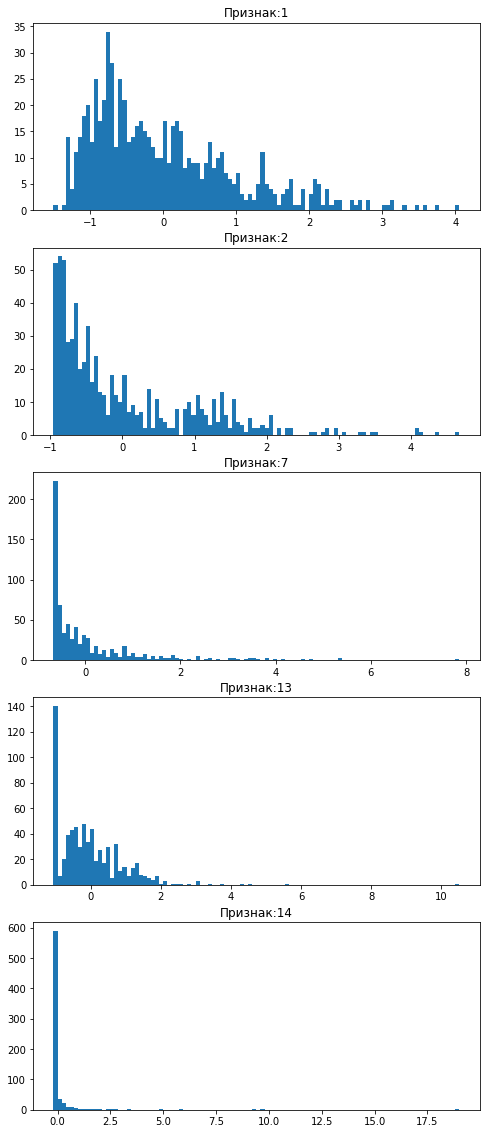

In [12]:
%matplotlib inline
fig, ax = plt.subplots(len(realCols[:-1]), 1, figsize=(8, 20))
for i in range(len(realCols[:-1])):
    # print('Признак:', realCols[i])
    buf = list(dfX[realCols[i]])
    ax[i].hist(buf, bins=100)
    ax[i].set_title('Признак:' + str(realCols[i]))

In [13]:
print('Целевой признак')
# dfY
unique, counts = np.unique(dfY, return_counts=True)
print('Классы:', unique)
print('Распределение:', counts / sum(counts) * 100)

Целевой признак
Классы: [0 1]
Распределение: [44.49275362 55.50724638]
